# Razer Classification
Classifying colour datasets in Razer keyboards (static)

### Note that first run creates directories, moves images around directories based on local file location of images. Change these to own local file location. Rerunning does not need resplitting of the directories as original folder would be empty. All data would be taken from split_data directory afterwards

It has 9 different classes which are listed below :<br>
**1. blue <br>**
**2. cyan <br>**
**3. faulty <br>**
**4. green <br>**
**5. orange <br>**
**6. pink <br>**
**7. red <br>**
**8. white <br>**
**9. yellow <br>**

In [ ]:
import os
import shutil
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import pathlib
from PIL import Image
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from keras.utils import plot_model

# from sklearn.model_selection import StratifiedKFold
# from sklearn.utils.class_weight import compute_class_weight
# from tensorflow.keras import metrics
# from tensorflow.keras.applications import VGG16
# import cv2
# import glob


# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

# Not needed, unless you want to merge everything back to original file (but haven't tried this code since it wasn't needed)
## Make the markdown below into code

### Define the paths
train_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\train"  # Path to the train data
val_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\val"  # Path to the validation data
test_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\test"  # Path to the test data
dataset_path = r"C:\Users\Yin Yu\Documents\LocalData\images\TrainingData"  # Original dataset path

### Get all class names (excluding any 'faulty_backup')
class_names = [d for d in sorted(os.listdir(dataset_path)) if os.path.isdir(os.path.join(dataset_path, d)) and d != "faulty_backup"]

### Function to move images to the class folder in train directory
def move_images_to_class_folder(image_list, class_name, target_dir):
    class_folder = os.path.join(target_dir, class_name)
    os.makedirs(class_folder, exist_ok=True)  # Create the class folder if it doesn't exist

    # Move each image to its respective class folder
    for img in image_list:
        shutil.move(img, os.path.join(class_folder, os.path.basename(img)))

### Move images from train, val, and test back to the train folder
def merge_and_move_images():
    # List all images in val and test directories
    all_images = []

    # Get images from validation and test sets and move to train set
    for split_dir in [val_dir, test_dir]:
        for class_name in class_names:
            class_split_path = os.path.join(split_dir, class_name)
            if os.path.exists(class_split_path):
                images = [os.path.join(class_split_path, img) for img in os.listdir(class_split_path) if img.lower().endswith((".jpg", ".png"))]
                move_images_to_class_folder(images, class_name, train_dir)  # Move these images to the correct class folder in train

                # Optionally, clear the val/test directories after moving
                for img in images:
                    os.remove(img)  # Remove the images from val and test (optional, for cleanup)

    print("Images successfully moved to respective class folders in train directory.")

### Call function to merge and move images
merge_and_move_images()

## Step 2: Data loading
Find image path and load in (Change accordingly to own file location)

In [2]:
##Data directory and path
dataset_path = r"C:\Users\Yin Yu\Documents\LocalData\images\TrainingData"
data_dir = pathlib.Path(dataset_path)


# Step 3: Data preprocessing
Understand, Augmentation, Visualization

### 1.One-hot encoding and number of images

In [3]:
# Get all class names (subfolders)
class_counts = {}

# Get all subfolder names (i.e., color class names)
class_names = sorted([name for name in os.listdir(dataset_path) if name != "faulty_backup"]) # Sorting ensures consistent mapping
class_to_index = {class_name: i for i, class_name in enumerate(class_names)}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a folder
        num_images = len(os.listdir(class_path))  # Count images
        class_counts[class_name] = num_images

print("Class Mapping:") #printing out the class mapping to index, e,g blue:0,.. helps machine in training
for color, index in class_to_index.items():
    print(f"{color}: {index}")

Class Mapping:
blue: 0
cyan: 1
faulty: 2
green: 3
orange: 4
pink: 5
red: 6
white: 7
yellow: 8


# No need to run next few cells if split_data already exists

In [4]:
for class_name, count in class_counts.items(): #see how many images in each colour folder, notice faulty_backup exists
    print(f"{class_name}: {count} images")

blue: 1 images
cyan: 0 images
faulty: 0 images
faulty_backup: 88 images
green: 1 images
orange: 1 images
pink: 0 images
red: 0 images
white: 0 images
yellow: 0 images


### 2.Data sorting, & balancing (downsample "Faulty")

In [38]:
#Reduce number of "Faulty" images
faultyset_path = r"C:\Users\Yin Yu\Documents\LocalData\images\TrainingData\faulty"
faulty_images = os.listdir(faultyset_path)
target_count = 150  

if len(faulty_images) > target_count:
    # Randomly select the images to keep
    downsampled_images = random.sample(faulty_images, target_count)

    # Create a backup folder for removed images (optional)
    backup_dir = faultyset_path + "_backup"
    os.makedirs(backup_dir, exist_ok=True)

    for img in faulty_images:
        if img not in downsampled_images:
            shutil.move(os.path.join(faultyset_path, img), os.path.join(backup_dir, img))

print(f"Downsampled 'faulty' class to {len(os.listdir(faultyset_path))} images.")
print(f"Moved {len(os.listdir(backup_dir))} images to backup.")

Downsampled 'faulty' class to 150 images.
Moved 88 images to backup.


In [39]:
# Recompute class counts after downsampling
class_counts = {}  # Reset the dictionary

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    # Exclude the backup folder from class counts
    if os.path.isdir(class_path) and class_name != "faulty_backup":  
        num_images = len(os.listdir(class_path))  
        class_counts[class_name] = num_images  # Update the count

print("\nUpdated class counts:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")


Updated class counts:
blue: 111 images
cyan: 105 images
faulty: 150 images
green: 133 images
orange: 114 images
pink: 113 images
red: 111 images
white: 107 images
yellow: 117 images


In [23]:
# Define original dataset path and new split directories
dataset_path = r"C:\Users\Yin Yu\Documents\LocalData\images\TrainingData"
output_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data"  # Directory to store splits
train_dir, val_dir, test_dir = [os.path.join(output_dir, x) for x in ["train", "val", "test"]]

# Ensure output directories exist
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Get the 9 class names (excluding faulty_backup)
class_names = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c)) and c != "faulty_backup"]

In [40]:
# Set split percentages
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

# Get list of class names excluding "faulty_backup"
class_names = [c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c)) and c != "faulty_backup"]

# Ensure directories exist for train, val, and test
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Create directories for train, val, and test
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Loop through each class (folder)
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path):  # Ensure it's a folder
        images = [img for img in os.listdir(class_path) if img.lower().endswith((".jpg", ".png"))]  # check for both jpg, png
        random.shuffle(images)  # Shuffle before splitting

        # Split into train (70%), temp (30%)
        train_files, temp_files = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
        
        # Split temp into validation (15%) and test (15%)
        val_files, test_files = train_test_split(temp_files, test_size=0.50, random_state=42)

        # Create class subfolders in train, val, test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Move files to respective directories
        for file in train_files:
            shutil.move(os.path.join(class_path, file), os.path.join(train_dir, class_name, file))

        for file in val_files:
            shutil.move(os.path.join(class_path, file), os.path.join(val_dir, class_name, file))

        for file in test_files:
            shutil.move(os.path.join(class_path, file), os.path.join(test_dir, class_name, file))

print("Dataset successfully split into Train (70%), Validation (15%), and Test (15%)!")


Dataset successfully split into Train (70%), Validation (15%), and Test (15%)!


# Can start running from here

In [2]:
# Define the directories
train_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\train"
val_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\val"
test_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\test"

# Function to count images in a directory for each class
def count_images_in_dir(directory):
    class_image_count = {}
    
    # Loop through each class (subdirectory)
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        
        if os.path.isdir(class_path):  # Ensure it's a folder
            # Count images in each class folder
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".png"))]
            class_image_count[class_name] = len(image_files)
    
    return class_image_count

# Count images in train, validation, and test directories
train_class_count = count_images_in_dir(train_dir)
val_class_count = count_images_in_dir(val_dir)
test_class_count = count_images_in_dir(test_dir)

# Print the counts
print("Train Set Image Counts:")
for class_name, count in train_class_count.items():
    print(f"{class_name}: {count} images")

print("\nValidation Set Image Counts:")
for class_name, count in val_class_count.items():
    print(f"{class_name}: {count} images")

print("\nTest Set Image Counts:")
for class_name, count in test_class_count.items():
    print(f"{class_name}: {count} images")

Train Set Image Counts:
blue: 76 images
cyan: 73 images
faulty: 104 images
green: 92 images
orange: 79 images
pink: 79 images
red: 77 images
white: 74 images
yellow: 81 images

Validation Set Image Counts:
blue: 17 images
cyan: 16 images
faulty: 23 images
green: 20 images
orange: 17 images
pink: 17 images
red: 17 images
white: 16 images
yellow: 18 images

Test Set Image Counts:
blue: 17 images
cyan: 16 images
faulty: 23 images
green: 20 images
orange: 17 images
pink: 17 images
red: 17 images
white: 17 images
yellow: 18 images


### 3. Data visualization
Visualize what the different types of keyboard images looks like in the training set

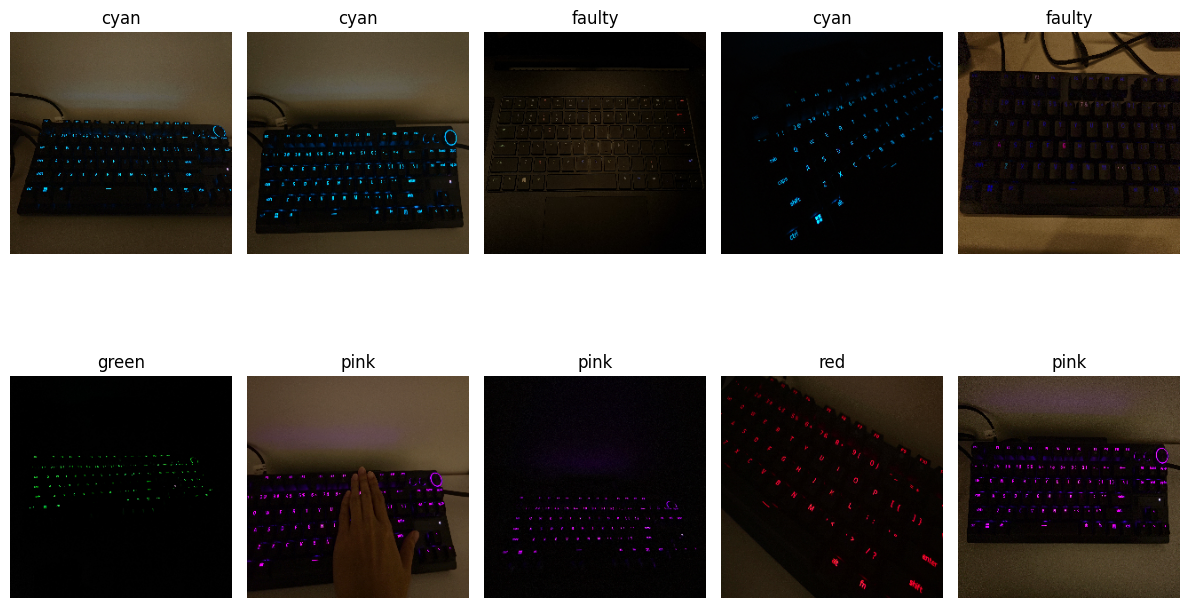

In [3]:
# Set the path to your training data
train_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\train"

# Get all class names (subfolders)
class_names = [c for c in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, c))]

# Set the number of images you want to inspect
num_images_to_display = 10

# Create a list to hold image file paths and their corresponding labels
image_paths = []
labels = []

# Loop through each class and collect image paths
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith((".jpg", ".png"))]
    for img in images:
        image_paths.append(os.path.join(class_path, img))
        labels.append(class_name)

# Randomly sample 10 images from the dataset
sampled_indices = random.sample(range(len(image_paths)), num_images_to_display)

# Plot the sampled images with their labels
plt.figure(figsize=(12, 8))

for i, idx in enumerate(sampled_indices):
    img_path = image_paths[idx]
    label = labels[idx]
    
    # Load the image using Keras
    img = image.load_img(img_path, target_size=(250, 250))
    
    # Convert to numpy array
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    
    # Plot the image
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
    plt.imshow(img_array)
    plt.title(label)
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

### 4. Data augmentation (Doesn't make changes to images in disk, but on-the-fly during training)

In [4]:
img_size = 250
batch_size = 16

train_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\train"
val_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\val"
test_dir = r"C:\Users\Yin Yu\Documents\LocalData\images\split_data\test"

# Apply augmentation to training & validation data
datagen = ImageDataGenerator(
    rescale=1./255, #normalization
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # no augmentation
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test data (NO AUGMENTATION)
test_datagen = ImageDataGenerator(rescale=1./255) #normalization
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Keep order to match labels
)

Found 735 images belonging to 9 classes.
Found 161 images belonging to 9 classes.
Found 162 images belonging to 9 classes.


In [5]:
print(test_generator.class_indices)

{'blue': 0, 'cyan': 1, 'faulty': 2, 'green': 3, 'orange': 4, 'pink': 5, 'red': 6, 'white': 7, 'yellow': 8}


## Step 4: Model training


In [15]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer for classification
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping],
)

# Save the model
model.save('../models/image_multiclass_model.h5')

# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Epoch 1/20
45/45 [==============================] - 64s 1s/step - loss: 1.8475 - accuracy: 0.3185 - val_loss: 1.0883 - val_accuracy: 0.7063
Epoch 2/20
45/45 [==============================] - 62s 1s/step - loss: 0.9585 - accuracy: 0.6801 - val_loss: 0.6334 - val_accuracy: 0.8562
Epoch 3/20
45/45 [==============================] - 63s 1s/step - loss: 0.6600 - accuracy: 0.7969 - val_loss: 0.6713 - val_accuracy: 0.8687
Epoch 4/20
45/45 [==============================] - 63s 1s/step - loss: 0.5220 - accuracy: 0.8345 - val_loss: 0.8569 - val_accuracy: 0.8250
Epoch 5/20
45/45 [==============================] - 63s 1s/step - loss: 0.5684 - accuracy: 0.8303 - val_loss: 0.5090 - val_accuracy: 0.8938
Epoch 6/20
45/45 [==============================] - 63s 1s/step - loss: 0.4333 - accuracy: 0.8623 - val_loss: 0.7713 - val_accuracy: 0.8687
Epoch 7/20
45/45 [==============================] - 61s 1s/step - loss: 0.4566 - accuracy: 0.8707 - val_loss: 0.5411 - val_accuracy: 0.8687
Epoch 8/20
45/45 [==

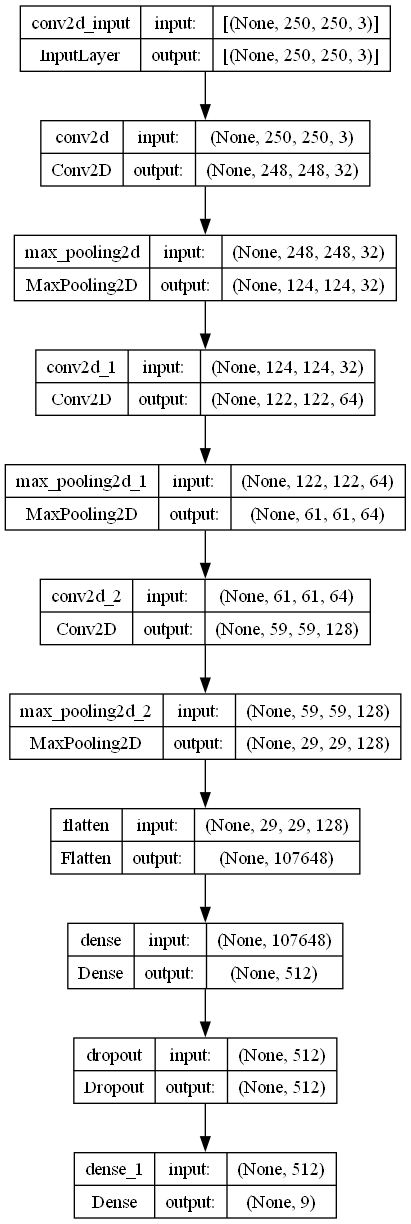

In [7]:
plot_model(model, to_file='image_multiclass_model_plot.png', show_shapes=True, show_layer_names=True)

Cross validation

## Step 5: Model Evaluation
Finally, we evaluate our model's performance using various metrics like accuracy, loss, and a confusion matrix. This will help us understand how well our model is performing and where it can be improved.

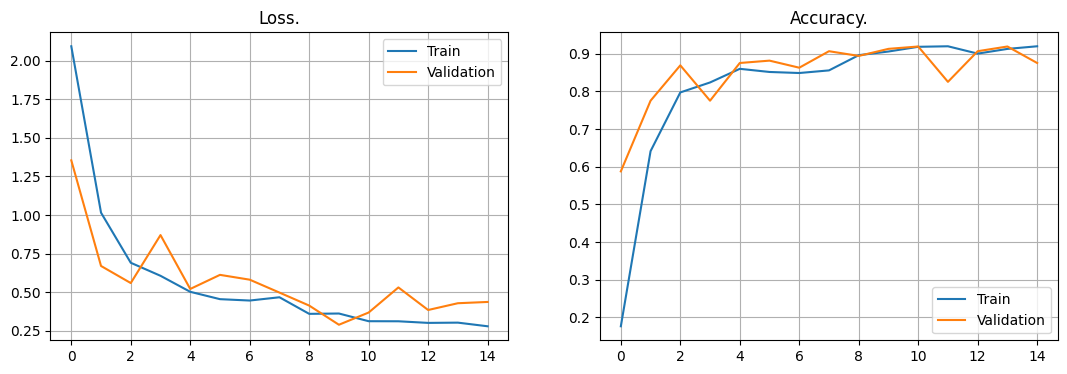

In [8]:
# Extracting metrics
metrics = history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

validation_loss = metrics["val_loss"]
validation_accuracy = metrics["val_accuracy"]

# Visualizing metrics
plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train");
plt.plot(validation_loss, label = "Validation");
plt.grid(True)
plt.legend(loc = "best");

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train");
plt.plot(validation_accuracy, label = "Validation");
plt.grid(True)
plt.legend(loc = "best");

11/11 [==============================] - 12s 1s/step


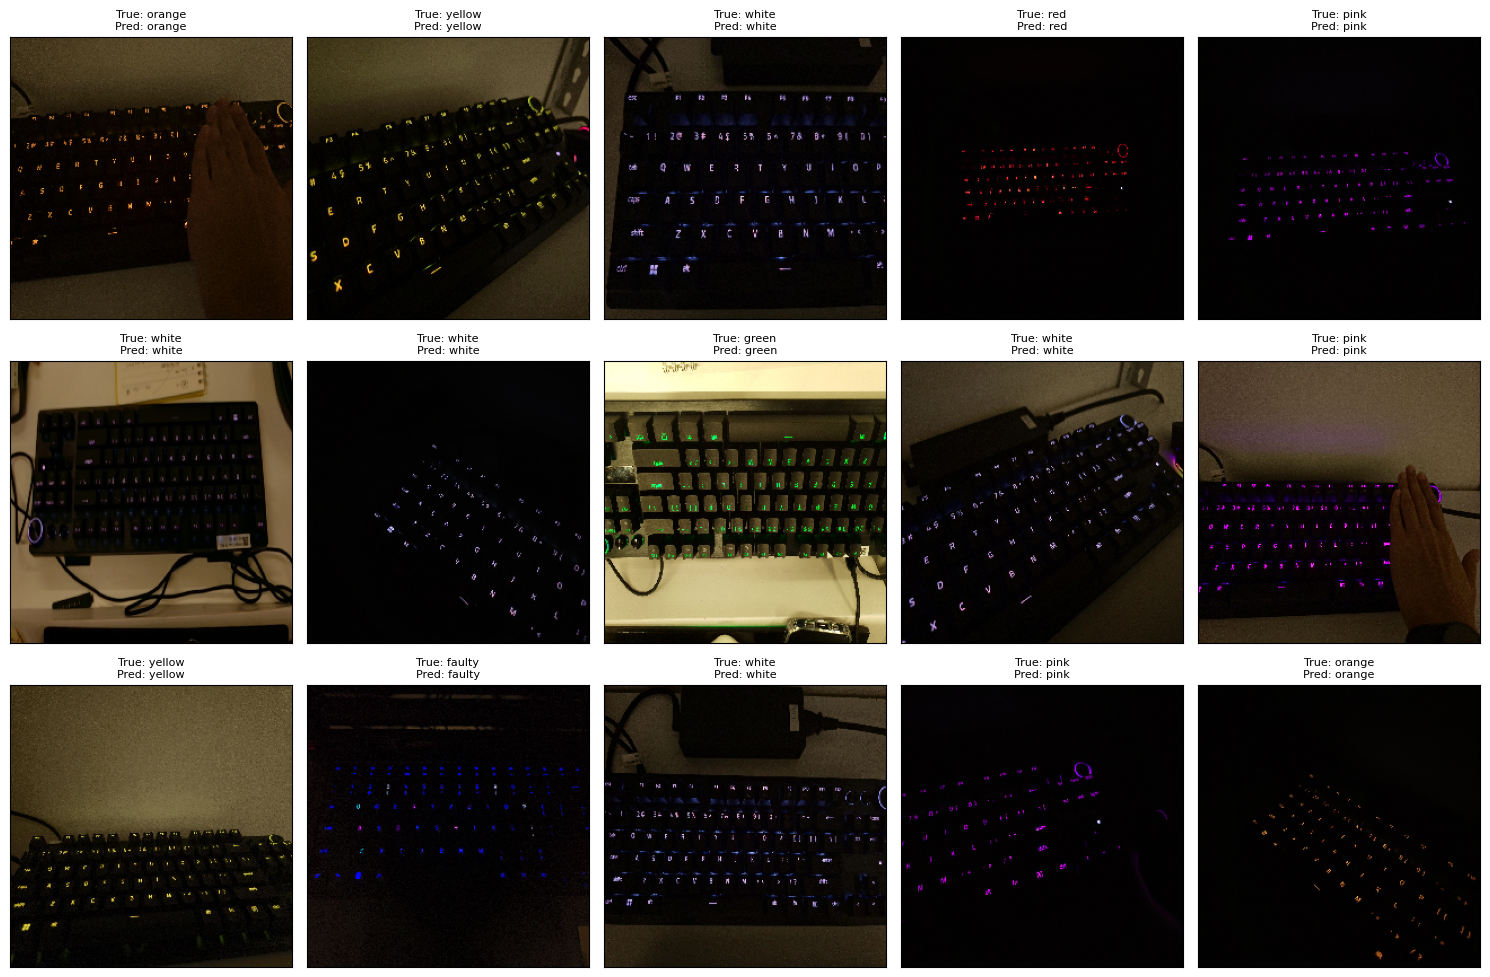

In [9]:
# Get test images and labels (you must reset the generator first)
test_generator.reset()
images, labels = next(test_generator)  # First batch

# Number of random images to display
num_random_images = 15

result = model.predict(test_generator)
# Convert predictions to class indices
predicted_class = np.argmax(result, axis=1)
true_class = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Choose random indices within the test set
random_indices = np.random.choice(len(predicted_class), size=num_random_images, replace=False)

# Plot
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    img = test_generator[idx // batch_size][0][idx % batch_size]  # Image
    true_label_index = true_class[idx]
    predicted_label_index = predicted_class[idx]

    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

    true_label_name = class_names[true_label_index]
    predicted_label_name = class_names[predicted_label_index]
    plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}", fontsize=8)

plt.tight_layout()
plt.show()


Text(0.5, 23.52222222222222, 'Predicted Class')

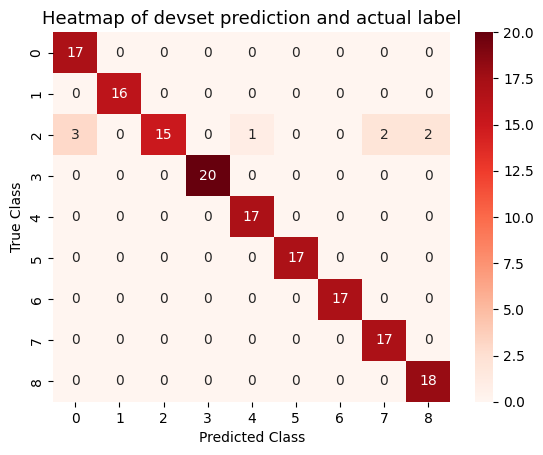

In [10]:
# Calculating confusion matrix
plt.title("Heatmap of devset prediction and actual label", fontsize = 13)
cm = confusion_matrix(true_class, predicted_class)
sns.heatmap(cm, cmap = "Reds", annot = True, fmt = "d")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")

In [11]:
# Understanding classification power of model on each class
report = classification_report(true_class, predicted_class)
print(report)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        17
           1       1.00      1.00      1.00        16
           2       1.00      0.65      0.79        23
           3       1.00      1.00      1.00        20
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        17
           7       0.89      1.00      0.94        17
           8       0.90      1.00      0.95        18

    accuracy                           0.95       162
   macro avg       0.95      0.96      0.95       162
weighted avg       0.96      0.95      0.95       162



In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 128)      0

1/1 [==============================] - 0s 15ms/step


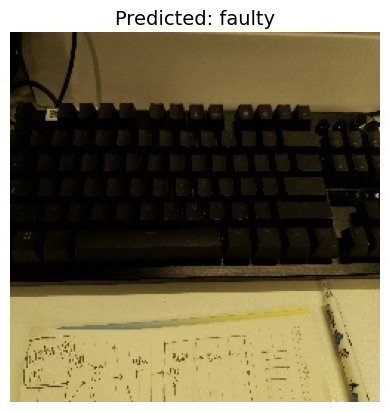

'faulty'

In [17]:
from tensorflow.keras.preprocessing import image as keras_image

def predict_single_image(img_path, model, class_indices, img_size):
    img = keras_image.load_img(img_path, target_size=(img_size, img_size))
    img_array = keras_image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction[0])

    index_to_class = {v: k for k, v in class_indices.items()}
    predicted_label = index_to_class[predicted_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}", fontsize=14)
    plt.show()

    return predicted_label


img_path = r"C:\Users\Yin Yu\Documents\LocalData\images\TestData\20241024_164221.jpg"
predict_single_image(img_path, model, test_generator.class_indices, img_size)

1/1 [==============================] - 0s 15ms/step


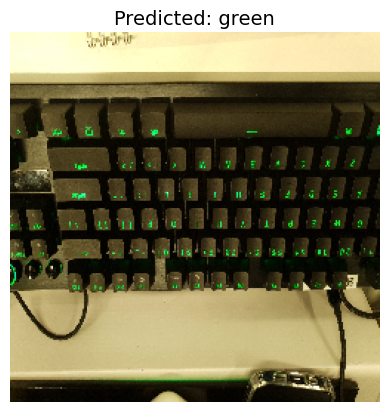

'green'

In [18]:
img_path = r"C:\Users\Yin Yu\Documents\LocalData\images\TestData\green_lit (4).jpg"
predict_single_image(img_path, model, test_generator.class_indices, img_size)

In [ ]:
# restored_model = tf.keras.models.load_model('../models/image_multiclass_model.h5')